# 多层感知 Multilayer Perceptron (MLP)

<img src="https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/images/logo.png" width=150>

本课程中，我们将学习神经网络的基本类型：多层感知。我们将使用 PyTorch 实现。

**注意**： 本文仅是用 PyTorch 对 MLPs 做介绍，因此我们不会按照机器学习技巧去简化（训练/测试拆分时的类平衡，验证集合，及早终止等）。我们将在下一文中实现最佳实践。



# 概览 Overview

<img src="https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/images/mlp.png" width=450>

$z_2 = XW_1$

$a_2 = f(z_2)$

$z_3 = a_2W_2$

$\hat{y} = softmax(z_3)$ # 类别

*其中*：
* $X$ = 输入 | $\in \mathbb{R}^{NXD}$ ($D$ 是特征的数量)
* $W_1$ = 第1层权重 | $\in \mathbb{R}^{DXH}$ ($H$ 是隐含层在第1层的单元数量)
* $z_2$ = 第1层权重的输出  $\in \mathbb{R}^{NXH}$
* $f$ = 非线性激活函数
* $a_2$ = 应用在第1层输出的激活值 | $\in \mathbb{R}^{NXH}$
* $W_2$ = 第2层权重 | $\in \mathbb{R}^{HXC}$ ($C$ 是类别数量)
* $\hat{y}$ = 预测 | $\in \mathbb{R}^{NXC}$ ($N$ 是采样数量)

这是简单的2层 MLP.

* **目的：**  基于给定的输入预测类别的概率。因为非线性数据，模型复杂度引入了非线性。
* **优势：**
  * 能很好的处理非线性模式。
* **劣势：**
  * 容易过拟合。
  * 计算精度取决于网络体积。
  * 不容易解释。
* **多样性：** 我们之后看到的未来神经网略架构使用 MLP 作为前馈操作（非线性操作之前的仿射变换）的一个模块单元。

# 训练 Training

*步骤*：

1. 随机初始化模型权重 $W$ （我们在之后的课程中将介绍更有效的初始化策略）。
2. 给予模型输入 $X$ 得到概率。
3. 比较预测值 $\hat{y}$ （例如  [0.3, 0.3, 0.4]]）和真实值 $y$ （例如 类别2将是 [0, 0, 1]），使用目标（代价）函数决定损失 $J$。分类任务常用的目标函数是交叉熵损失(Cross Entropy Loss)。
  * $z_2 = XW_1$
  * $a_2 = max(0, z_2)$ # ReLU 激活函数
  * $z_3 = a_2W_2$
  * $\hat{y} = softmax(z_3)$
  * $J(\theta) = - \sum_i y_i ln (\hat{y_i}) $
4. 计算损失 $J(\theta)$ w.r.t 对模型权重的梯度。
   * $ \frac{\partial{J}}{\partial{W_{2j}}} = a_2\hat{y}, \frac{\partial{J}}{\partial{W_{2y}}} = a_2(\hat{y}-1) $
   * $ \frac{\partial{J}}{\partial{W_1}} = \frac{\partial{J}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{a_2}}  \frac{\partial{a_2}}{\partial{z_2}}  \frac{\partial{z_2}}{\partial{W_1}}  = W_2(\partial{scores})(\partial{ReLU})X $
   
5. 应用反向传播法（backpropagation）到使用梯度下降更新权重 $W$ 。这些更新将减少错误类别（j）的概率，增加正确类别（y）的概率。
  * $W_i = W_i - \alpha\frac{\partial{J}}{\partial{W_i}}$
6. 重复步骤2-4，直到模型收敛。

# 数据 Data

我们将为分类任务生成一些非线性数据。

In [ ]:
# Load PyTorch library
!pip3 install torch torchvision

In [1]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [2]:
# Arguments
args = Namespace(
    seed=1234,
    num_samples_per_class=500,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=100,
    learning_rate=1e-0,
    regularization=1e-3,
    num_epochs=200,
)

# Set seed for reproducability
np.random.seed(args.seed)

In [3]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j,num_samples_per_class*(j+1))
        r = np.linspace(0.0,1,num_samples_per_class) # radius
        t = np.linspace(j*4,(j+1)*4,num_samples_per_class) + \
        np.random.randn(num_samples_per_class)*0.2 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    # Stack
    X = np.hstack([X_original])

    return X, y

In [4]:
# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class,
                     dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

X: (1500, 2)
y: (1500,)


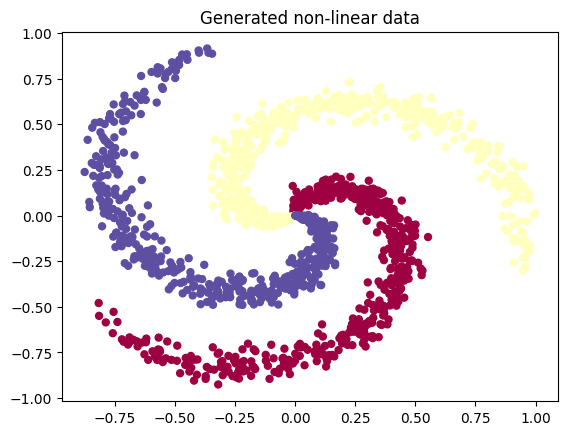

In [5]:
# Visualize data
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap=plt.cm.Spectral)
plt.show()

In [6]:
# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [7]:
# Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx]
y_train = y[:test_start_idx]
X_test = X[test_start_idx:]
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 1125 train samples and 375 test samples.


# 线性模型 Linear model

在使用神经网络之前，我们先用 PyTorch 的线性模型（逻辑回归）试一下。我们想看看为什么线性模型不能满足数据要求。

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [9]:
# Linear model
class LogisticClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LogisticClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = self.fc1(x_in)
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [10]:
# Initialize model
model = LogisticClassifier(input_dim=args.dimensions,
                           hidden_dim=args.num_hidden_units,
                           output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [11]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) # Adam optimizer (usually better than SGD)

In [12]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [13]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)

    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Verbose
    if t%20==0:
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.1104 | acc: 31.6%
epoch: 20 | loss: 13.8979 | acc: 54.5%
epoch: 40 | loss: 3.2195 | acc: 52.0%
epoch: 60 | loss: 1.2683 | acc: 54.8%
epoch: 80 | loss: 0.7472 | acc: 54.5%
epoch: 100 | loss: 0.7333 | acc: 54.8%
epoch: 120 | loss: 0.7282 | acc: 53.9%
epoch: 140 | loss: 0.7277 | acc: 54.1%
epoch: 160 | loss: 0.7277 | acc: 54.4%
epoch: 180 | loss: 0.7277 | acc: 54.4%


In [14]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [15]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 54.3%, test acc: 53.3%


In [16]:
# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

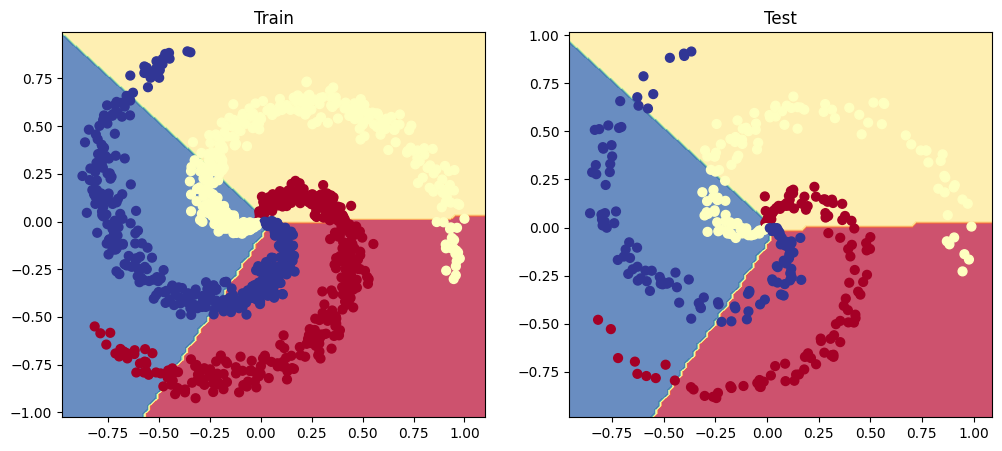

In [17]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

In [18]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

              precision    recall  f1-score   support

           0       0.53      0.49      0.51       126
           1       0.54      0.58      0.56       126
           2       0.52      0.53      0.52       123

    accuracy                           0.53       375
   macro avg       0.53      0.53      0.53       375
weighted avg       0.53      0.53      0.53       375



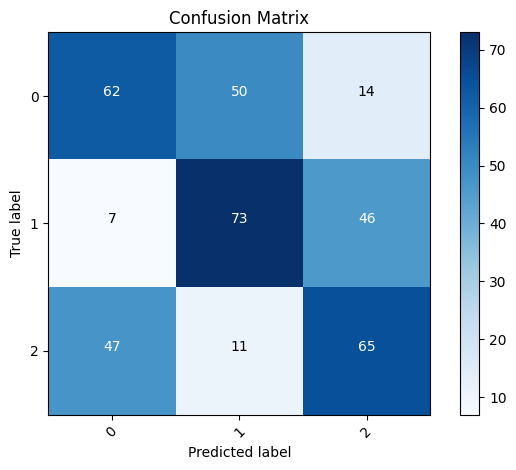

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

# 非线性模型 Non-linear model

现在，我们按一下 MLP 如何工作的。注意：和之前唯一的区别是增加了非线性的激活函数（我们使用 ReLU $max(0, z)）。

In [21]:
# Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [22]:
# Initialize model
model = MLP(input_dim=args.dimensions,
            hidden_dim=args.num_hidden_units,
            output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [23]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [24]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)

    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Verbose
    if t%20==0:
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.0847 | acc: 33.5%
epoch: 20 | loss: 0.5844 | acc: 69.9%
epoch: 40 | loss: 0.4643 | acc: 77.2%
epoch: 60 | loss: 0.3409 | acc: 84.8%
epoch: 80 | loss: 0.2418 | acc: 91.1%
epoch: 100 | loss: 0.1515 | acc: 94.1%
epoch: 120 | loss: 0.0512 | acc: 98.2%
epoch: 140 | loss: 0.0261 | acc: 99.6%
epoch: 160 | loss: 0.0208 | acc: 99.7%
epoch: 180 | loss: 0.0181 | acc: 99.7%


In [25]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [26]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 99.7%, test acc: 99.2%


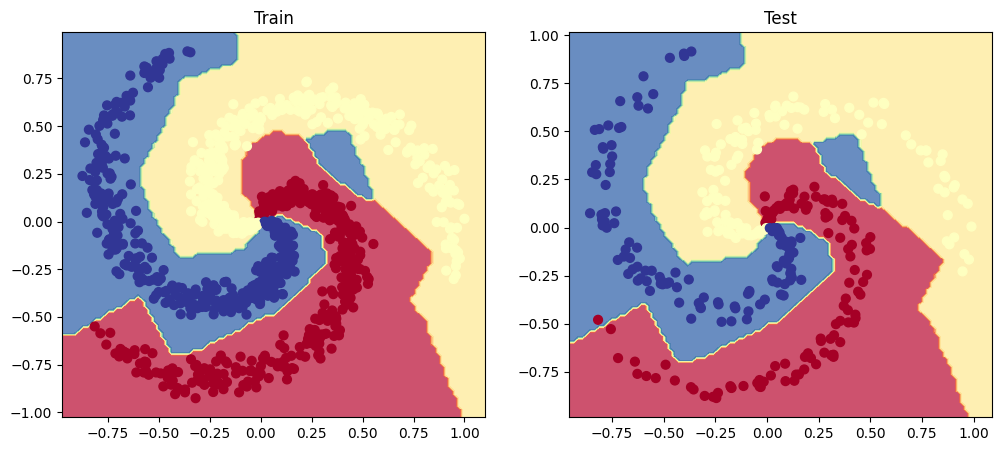

In [27]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       126
           1       1.00      0.99      1.00       126
           2       0.98      1.00      0.99       123

    accuracy                           0.99       375
   macro avg       0.99      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375



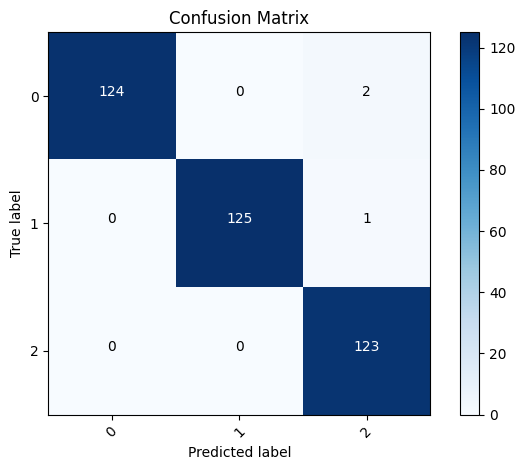

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

# 权重可视化 Visualizing weights

截至现在，我们看到了损失（loss）和精度（accuracy）等指标，甚至决策边界的可视化。但是我们的权重呢？因为他们数量太多，且在一直变化，所以可视化起来有些复杂。但这是必要的，因为权重会引起很多下游问题，例如所有权重趋近于0或者权重数量级快速增长。这些问题表示我们的模型需要一些调整/标准化。我们要能噶偶看到权重的这些变化。因为权重有维度很大，我们也需要不同参数均值和标准差的可视化。

我们使用 [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) 和 PyTorch 可视化所有内容。Tensorboard 可以用于本地可视化，但是在  Google colab 上有些复杂，所以我们使用一个 localtunnel 显示 notebook 服务器。如果你在本地电脑进行，只需要在终端运行 `tensorboard --logdir='./logs' --port=6006` ，在`http://localhost:6006`打开TensorBoard。

<img src="https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/images/tensorboard.png" width=600>

以下是易于测量和可视化参数：
1. 损失和精度
2. 权重均值和标准差
3. 激活函数均值和标准差
4. 梯度均值和标定差

In [ ]:
# Install TensorboardX
!pip3 install tensorboardX

    100% |████████████████████████████████| 71kB 2.7MB/s 


In [ ]:
# Run tensorboard on port 6006
LOG_DIR = './log'
run_num = 0
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
# Install localtunnel
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.1
added 54 packages from 32 contributors in 3.207s


In [ ]:
# Tunnel port 6006 for tensorboard
get_ipython().system_raw('lt --port 6006 >> tensorboard.txt 2>&1 &')

现在我们开始训练模型，并在 tensorboard 做些可视化。

In [ ]:
# Few things needed to get tensorboard working
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions):
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

    100% |████████████████████████████████| 5.6MB 5.9MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.3MB 4.4MB/s 


In [ ]:
# Initialize the Tensorboard writer
run_num += 1
writer = SummaryWriter(log_dir=LOG_DIR+"/run_{}".format(run_num))

In [ ]:
# Initialize model
model = MLP(input_dim=args.dimensions,
            hidden_dim=args.num_hidden_units,
            output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [ ]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [ ]:
 def write_weights(writer, model, epoch_num):
    for name, param in model.named_parameters():

        # Weights
        writer.add_scalar(name+"/mean", param.data.numpy().mean(), epoch_num)
        writer.add_scalar(name+"/std", param.data.numpy().std(), epoch_num)

        # Gradients
        writer.add_scalar(name+"/grad_mean", torch.mean(param.grad), epoch_num)
        writer.add_scalar(name+"/grad_std", torch.std(param.grad), epoch_num)

        # Weights histogram (dim over 1024 cause an error)
        if len(param.size()) > 1 and param.size()[-1] <= 1024:
            writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch_num)

In [ ]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)

    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Verbose
    if t%20==0:
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Write to tensorboard
    writer.add_scalar('metrics/train_loss', loss, t)
    writer.add_scalar('metrics/train_acc', accuracy, t)
    writer.add_scalar('metrics/lr', optimizer.param_groups[0]['lr'], t)
    write_weights(writer=writer, model=model, epoch_num=t)

epoch: 00 | loss: 1.1047 | accuracy: 34.0%
epoch: 20 | loss: 0.7275 | accuracy: 56.0%
epoch: 40 | loss: 0.3969 | accuracy: 79.3%
epoch: 60 | loss: 0.2519 | accuracy: 82.0%
epoch: 80 | loss: 0.1990 | accuracy: 86.0%
epoch: 100 | loss: 0.1586 | accuracy: 90.7%
epoch: 120 | loss: 0.1289 | accuracy: 92.9%
epoch: 140 | loss: 0.1018 | accuracy: 95.2%
epoch: 160 | loss: 0.0806 | accuracy: 96.4%
epoch: 180 | loss: 0.0467 | accuracy: 98.7%


In [ ]:
print ("Go to this link below to see the Tensorboard:")
!cat tensorboard.txt
print ("Click on SCALARS to see metrics and DISTRIBUTIONS to see weights.")

Go to this link below to see the Tensorboard:
your url is: https://tame-puma-78.localtunnel.me
Click on SCALARS to see metrics and DISTRIBUTIONS to see weights.


# 激活函数 Activation functions

在我们的 MPL 中，我们使用了 ReLU 激活函数（$max(0,z))），这是目前最常用的。当然还有其他几种激活函数，各有特点。

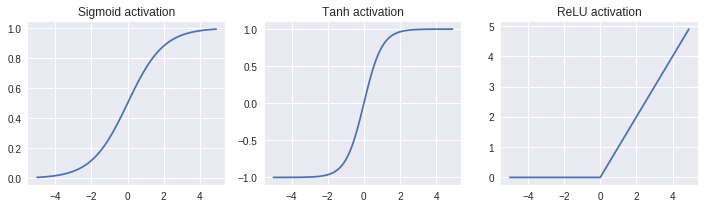

In [ ]:
# Fig size
plt.figure(figsize=(12,3))

# Data
x = torch.arange(-5., 5., 0.1)

# Sigmoid activation (constrain a value between 0 and 1.)
plt.subplot(1, 3, 1)
plt.title("Sigmoid activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh activation (constrain a value between -1 and 1.)
plt.subplot(1, 3, 2)
y = torch.tanh(x)
plt.title("Tanh activation")
plt.plot(x.numpy(), y.numpy())

# Relu (clip the negative values to 0)
plt.subplot(1, 3, 3)
y = F.relu(x)
plt.title("ReLU activation")
plt.plot(x.numpy(), y.numpy())

# Show plots
plt.show()

# 初始化权重 Initializing weights

目前为止，我们使用小随机数做了权重初始化，但不是模型训练收敛的最优值。目标是得到一个在所有神经元都能有相似分布输出的权重。我们可以采用相比仿射和非线性操作，更优先考虑单位方差的权重。
常用的方法是使用 [xavier 初始化](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)，可以使信号从数据到每一层次网络。我们将在 PyTorch 模型中使用这个方法。
你可能会问：为什么我们不在每一个前向传播中使用？这是一个好问题。我们将在后续课程中学习更高级的优化方法，例如 批量/层正则化。

In [ ]:
# Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

# 过拟合 Overfitting

虽然神经网络很善于处理非线性数据关系，也容易在测试数据上过拟合，不能通过测试数据。如下面例子所示，我们生成完全随机的数据，能够拟合一个有 [$2*N*C + D$](https://arxiv.org/abs/1611.03530)  隐含层的模型。训练结果非常好，但是过拟合导致在测试数据表现很差。我们将在后续课程中学习解决过拟合的方法。

In [ ]:
# Arguments
args = Namespace(
    seed=1234,
    num_samples_per_class=40,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=2*40*3+2 , # 2*N*C + D
    learning_rate=1e-3,
    regularization=1e-3,
    num_epochs=1000,
)

# Set seed for reproducability
np.random.seed(args.seed)

In [ ]:
# Generate random data
X = torch.randn(args.num_samples_per_class*args.num_classes, args.dimensions).float()
y = torch.LongTensor([[i]*args.num_samples_per_class
                       for i in range(args.num_classes)]).view(-1)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

X: torch.Size([120, 2])
y: torch.Size([120])


In [ ]:
# Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx]
y_train = y[:test_start_idx]
X_test = X[test_start_idx:]
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 90 train samples and 30 test samples.


In [ ]:
# Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        print
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in))
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [ ]:
# Initialize model
model = MLP(input_dim=args.dimensions, hidden_dim=args.num_hidden_units,
            output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=242, bias=True)
  (fc2): Linear(in_features=242, out_features=3, bias=True)
)>


In [ ]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [ ]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)

    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Verbose
    if t%100==0:
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.1201 | accuracy: 35.6%
epoch: 100 | loss: 0.9448 | accuracy: 51.1%
epoch: 200 | loss: 0.8145 | accuracy: 66.7%
epoch: 300 | loss: 0.7117 | accuracy: 72.2%
epoch: 400 | loss: 0.6309 | accuracy: 76.7%
epoch: 500 | loss: 0.5663 | accuracy: 80.0%
epoch: 600 | loss: 0.5146 | accuracy: 82.2%
epoch: 700 | loss: 0.4734 | accuracy: 82.2%
epoch: 800 | loss: 0.4378 | accuracy: 83.3%
epoch: 900 | loss: 0.4063 | accuracy: 85.6%


In [ ]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [ ]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 87.8%, test acc: 43.3%


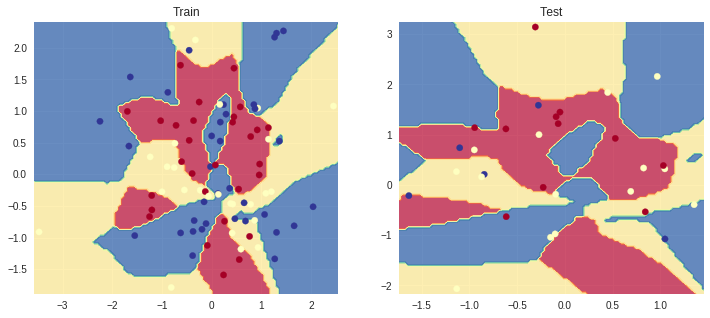

In [ ]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

             precision    recall  f1-score   support

          0       0.47      0.73      0.57        11
          1       0.57      0.29      0.38        14
          2       0.17      0.20      0.18         5

avg / total       0.47      0.43      0.42        30



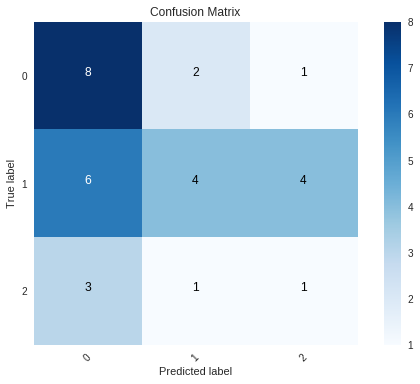

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

# 丢弃 Dropout

增加数据是解决过拟合非常好的方法，但通常不可行。幸运的是，有正则化和 dropout 可以帮助我们床一个鲁棒性更好的模型。我们已经介绍过正则化，可以很方便的添加到 PyTorch 模型中。
dropout（只用于训练）允许我们消除神经元的输出。我们用在每一层 p% 的神经元，这个概率每批都变。dropout 避免了神经单元和数据的共适应，类似于一个采样策略，每次丢弃了一个不同的神情元组合。


<img src="https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/images/dropout.png" width=400>

In [ ]:
# Arguments
args.dropout_p = 0.1 # 40% of the neurons are dropped each pass
args.lambda_l2 = 1e-4 # L2 regularization

In [ ]:
# Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p) # Defining the dropout
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in))
        z = self.dropout(z) # dropping neurons
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [ ]:
# Initialize model
model = MLP(input_dim=args.dimensions,
            hidden_dim=args.num_hidden_units,
            output_dim=args.num_classes,
            dropout_p=args.dropout_p)
print (model.named_modules)

# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate,
                       weight_decay=args.lambda_l2) # Adding L2 regularization

# Training
pass

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=242, bias=True)
  (dropout): Dropout(p=0.1)
  (fc2): Linear(in_features=242, out_features=3, bias=True)
)>


# 其他资源 Additional resources

- interpretability (easy w/ at with binary tasks)
- dropconnect (but not really used)
- PReLU 激活函数